In [40]:
import os
import numpy as np
import torch
import geopandas as gpd

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

import pyro 
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS, Predictive, SVI, RenyiELBO

import matplotlib.pyplot as plt
import plotly.express as px
from termcolor import colored


## Helper Funcs

In [41]:
DEVICE = "cuda" if torch.cuda.is_available else "cpu"

def check_tensor_cuda(t):
    assert isinstance(x, torch.Tensor) and x.is_cuda, colored("Var not a torch tensor or not using cuda","red")


## GP Kernel Funcs

In [42]:
def dist_euclid(x:torch.Tensor,z:torch.Tensor)->torch.Tensor:
    """
    x : Lat/Lon values, Shape : (*,2)
    z : Also lat/lon values in this situation 
    """
    check_tensor_cuda(x);check_tensor_cuda(z)

    if len(x.shape) == 1:
        x = x.reshape(x.shape[0], 1) #shape : (num_grid_pts, 1)
    if len(z.shape) == 1:
        z = z.reshape(z.shape[0], 1) #shape : (num_grid_pts, 1)

    n_x , m = x.shape
    n_z , m_z = z.shape 
    assert m == m_z

    delta = torch.zeros((n_x, n_z)).to(DEVICE) #shape : (num_grid_pts, num_grid_pts)
    for d in torch.arange(m): #num_grid_pts ; i.e 0..1919
        x_d = x[:, d] #take col vector from sq mat
        z_d = z[:, d]
        delta = (x_d.unsqueeze(1) - z_d)**2 
    
    check_tensor_cuda(delta)
    return torch.sqrt(delta) #shape : (num_grid_pts, num_grid_pts) 

def exp_sq_kernel(x:torch.Tensor,z:torch.Tensor,var:float, length:float, noise:float, jitter = 1e-4)->torch.Tensor:
    """
    Kernel Function
    Inputs 
        - x : Lat/Lon values of grid points
        - z : Lat/Lon values of grid points
        - var : variance hyperparam for kernel
        - length : length hyperparam for kernel
        - noise : noise
        - jitter : some noise for numerical stability
    """
    check_tensor_cuda(x) ; check_tensor_cuda(z)

    dist = dist_euclid(x,z) #shape : (num_grid_pts, num_grid_pts)
    deltaXsq = torch.pow(dist/length, 2.0) #square dist
    k = var * torch.exp(-0.5 * deltaXsq)
    k += (noise + jitter) * torch.eye(x.shape[0]).to(DEVICE)

    check_tensor_cuda(k)
    return k #shape : (num_grid_points, num_grid_points) 

## Aggregation Funcs

In [43]:
def M_g(M:torch.Tensor,g:torch.Tensor):
    """
    Aggregation function
    Inputs
        - M : Matrix with binary entries m_{ij} show wheather point j is in polygon i 
        - g : Vector of Gp draws over grid 
    Output
        - matmul(M,g) : Vector of sums over each polygon
    """
    check_tensor_cuda(M) ; check_tensor_cuda(g)

    return torch.matmul(M,g) #shape : (num_regions,)

#* This is slightly different from the gp.py script version which does the sampling posterior as well
def gp_aggr(args):
    """
    Aggregated GP
    Inputs
        - args : Dictionary containing the following 
            - n_obs : number of observations/cases ; shp : (num_all_regions,) <- all regions include both hi res and low res regions
            - x : lat/lon grid point values ; shp : (num_grid_pts, 2)
            - gp_kernel : exponential kernel function
            - jitter : random noise for numerical stability ; scaler
            - M1 (M_lo/M_old) : Matrix with binary entries m_{ij} show wheather point j is in polygon i 
            - M2 (M_hi/M_new) : Matrix with binary entries m_{ij} show wheather point j is in polygon i 
    """
    x = args["x"]
    gp_kernel = args["gp_kernel"]
    jitter = args["jitter"]
    noise = args["noise"]
    M1 = args["M1"] #Low
    #! ASK SWAPNIL : We dont train on High Resolution data Right
    #M2 = args["M2"] #new/hi

    check_tensor_cuda(x); 
    check_tensor_cuda(M1); 
    #check_tensor_cuda(M2)

    length = pyro.sample("kernel_length", dist.InverseGamma(3,3)).to(DEVICE)
    var = pyro.sample("kernel_var", dist.HalfNormal(0.05)).to(DEVICE)
    k = gp_kernel(x,x,var,length,noise,jitter)
    f = pyro.sample(
        "f", 
        dist.MultivariateNormal(loc = torch.zeros(x.shape[0]).to(DEVICE), covariance_matrix = k)
    ).to(DEVICE)

    # Aggregate
    gp_aggr_m1 = pyro.deterministic("gp_aggr_m1", M_g(M1,f)).to(DEVICE) #shp : (num_regions_m1,)
    #! NO NEED TO CONCATENATE 
    # gp_aggr_m2 = pyro.deterministic("gp_aggr_m2", M_g(M2,f)).to(DEVICE) #shp : (num_regions_m2,)
    # gp_aggr = pyro.deterministic("gp_aggr", torch.cat([gp_aggr_m1, gp_aggr_m2])).to(DEVICE) #shp : (num_regions_m1 + num_regions_m2,)


## VAE Funcs

In [44]:
class VaeEncoder(nn.Module):
    def __init__(self, input_dim = 2, hidden_dim = 1000, z_dim = 80):
        super(VaeEncoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, z_dim)
        self.fc22 = nn.Linear(hidden_dim, z_dim)

    def forward(self, x): # x.shape : (1920,2) 
        z = F.elu(self.fc1(x)) #(num_grid_pts, 2) -> (num_grid_pts, 50) where batch_size = num_grid_pts
        z_mu = self.fc21(z) #(num_grid_pts, 50) -> (num_grid_pts, 40)
        z_sigma = torch.exp(self.fc22(z)) #(num_grid_pts, 50) -> (num_grid_pts, 40)
        
        check_tensor_cuda(z_mu) ; check_tensor_cuda(z_sigma)
        return z_mu, z_sigma

class VaeDecoder(nn.Module):
    def __init__(self, z_dim = 40, hidden_dim = 40, output_dim = 2):
        super(VaeDecoder,self).__init__()
        self.fc1 = nn.Linear(z_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.z_dim = z_dim

    def forward(self, z): #z.shape (1920, 40)
        z_new = F.elu(self.fc1(z)) #(num_grid_pts, 40) -> (num_grid_pts, 50) where num_grid_pts == batch_soze 
        x_recon = self.fc2(z_new) #(num_grid_pts, 50) -> (num_grid_pts, 2)

        check_tensor_cuda(x_recon)
        return x_recon

class VAE(nn.Module):
    def __init__(self, input_dim = 2,  hidden_dim = 50, z_dim = 40, output_dim = 2):
        super(VAE, self).__init__()

        self.encoder = VaeEncoder(input_dim, hidden_dim, z_dim)
        self.decoder = VaeDecoder(z_dim , hidden_dim, output_dim)
        self.z_dim = z_dim

    def guide(self, x):
        """Variational Distribution , q(z|x)"""
        pyro.module("encoder", self.encoder)
        with pyro.plate("data", x.shape[0]):
            z_mu, z_sigma = self.encoder.forward(x) #(num_grid_pts, 40),(num_grid_pts, 40)
            check_tensor_cuda(z_mu) ; check_tensor_cuda(z_sigma)
            # sample the latent z
            z = pyro.sample("latent", dist.Normal(z_mu, z_sigma).to_event(1))
            #print(f"latent z : {colored(z, 'red')}")
            return z

    def model(self, x):
        pyro.module("decoder", self.decoder)
        with pyro.plate("data", x.shape[0]):
            z_mu = x.new_zeros(torch.Size((x.shape[0], self.z_dim))) #(num_grid_pts, 40)
            z_sigma = x.new_ones(torch.Size((x.shape[0], self.z_dim))) #(num_grid_pts, 40)
            z = pyro.sample("latent", dist.Normal(z_mu,z_sigma).to_event(1))
            gen_mu = self.decoder(z) #(num_grid_pts, 2)
            pyro.sample("obs", dist.Normal(gen_mu, 1).to_event(1), obs = x) #we have set the variance to 1

def training_loop(x,args):
    input_dims  = args["input_dims"]
    hidden_dims = args["hidden_dims"]
    z_dim = args["z_dim"]
    output_dims = args["output_dims"]
    num_epochs = args["num_epochs"]
    learning_rate = args["learning_rate"]

    vae = VAE(input_dims,hidden_dims,z_dim,output_dims)
    vae = vae.to(DEVICE)
    optimizer = pyro.optim.Adam({"lr" : learning_rate})
    svi = SVI(vae.model, vae.guide, optimizer, loss = RenyiELBO())

    losses = []
    for epoch in range(num_epochs):
        print(f"epoch : {epoch}")
        x = x.to(DEVICE)
        train_loss = svi.step(x) #* DOES SVI STEP HANDLE GRADIENTS
        losses.append(train_loss)
        print(f"Train Loss : {train_loss}")

    return vae, losses


## Load Data

In [45]:
data_dir = "../data/processed"

# Lat/Lon Values of artificial grid
x = np.load(os.path.join(data_dir,"lat_lon_x.npy"))
pol_pt_lo = np.load(os.path.join(data_dir, "low/pol_pt_lo.npy"))
pol_pt_hi = np.load(os.path.join(data_dir, "high/pol_pt_hi.npy"))
df_lo = gpd.read_file(os.path.join(data_dir, "low", "us_census_divisions", "us_census_divisions.shp"))
df_hi = gpd.read_file(os.path.join(data_dir, "high", "us_state_divisions", "us_state_divisions.shp"))

# Convert to Torch Tensors
x = torch.tensor(x, dtype = torch.float32).to(DEVICE)
pol_pt_lo = torch.tensor(pol_pt_lo, dtype = torch.float32).to(DEVICE)
pol_pt_hi = torch.tensor(pol_pt_hi, dtype = torch.float32).to(DEVICE)
# This is your y
n_obs = torch.tensor(df_lo.tot_cases, dtype = torch.int32).to(DEVICE)

## Prior Predictive Check

In [46]:
args = {
    "n_obs" : n_obs,
    "x" : x,
    "gp_kernel" : exp_sq_kernel,
    "jitter" : 1e-4,
    "noise" : 1e-4,
    "M1" : pol_pt_lo,
    #! WE dont neew Hi-Res but if we do 
    #"M2" : pol_pt_new,

    # VAE training
    "num_epochs" : 20,
    "learning_rate" : 0.0005,
    "batch_size" : 100,
    "input_dims" : 2,
    "hidden_dims" : 50,
    "z_dim" : 40,
    "output_dims" : 2,
    "num_train" : 100,
    "num_test" : 100,
    "vae_var" : 1
}

In [47]:
agg_gp_predictive = Predictive(gp_aggr, num_samples = 500)
agg_gp_preds = agg_gp_predictive(args)
agg_gp_draws = agg_gp_preds["gp_aggr_m1"]

p1 = px.line()
#map(lambda x: p1.add_scatter(x = np.arange(1,10), y = agg_gp_draws[x :]), np.arange(len(agg_gp_draws)))

for i in range(len(agg_gp_draws)):
    p1.add_scatter(
        x = np.arange(1,10), 
        y = agg_gp_draws[i, :].to("cpu").numpy(), 
        line_color = "black", 
        line_width = 0.5,
        opacity = 0.2
    )
p1.update_layout(
    template = "plotly_white", 
    xaxis_title = "Region Index", yaxis_title = "Num Cases", 
    title = "Prior Predictive Simulation",
    showlegend = False
)
p1.show()


In [48]:
agg_gp_draws.shape

torch.Size([500, 9])

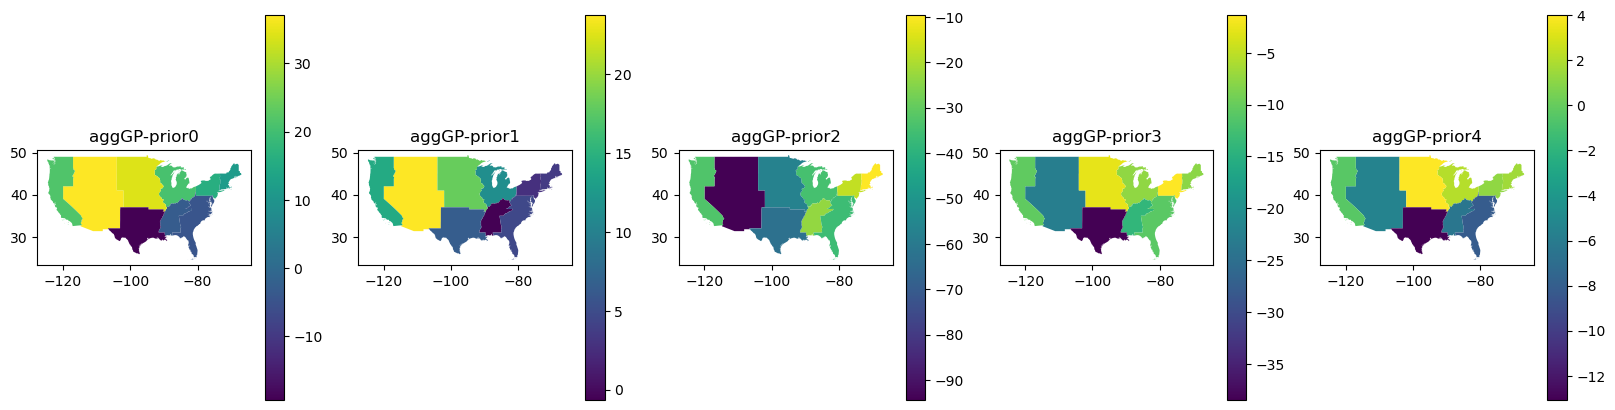

In [49]:
# First 5 samples
fig, axs = plt.subplots(1,5, figsize = (20,5))
df_lo2 = df_lo.copy()
for i in range(5):
    nm = f"gp_aggr_{i}"
    df_lo2[nm] = agg_gp_draws[i, :].to("cpu").numpy()
    df_lo2.plot(column = nm, ax = axs[i], legend = True)
    axs[i].set_title("aggGP-prior" + str(i))
    

In [50]:
#! Check with Swapnil if we need to do this for HI resolution data

## Are th Priors approporate ?

## Train VAE

In [51]:
vae, losses = training_loop(x, args)

epoch : 0
Train Loss : 5.069411502595125e+33
epoch : 1
Train Loss : 3.796802643024548e+33
epoch : 2
Train Loss : 3.520462858785049e+33
epoch : 3
Train Loss : 3.192828410047741e+33
epoch : 4
Train Loss : 3.3711824548127136e+33
epoch : 5
Train Loss : 3.1777376114838426e+33
epoch : 6
Train Loss : 3.7502387663868676e+33
epoch : 7
Train Loss : 5.076474260004258e+33
epoch : 8
Train Loss : 2.768833327622479e+33
epoch : 9
Train Loss : 4.149969914557127e+33
epoch : 10
Train Loss : 4.5303254442025107e+33
epoch : 11
Train Loss : 5.448440888973425e+33
epoch : 12
Train Loss : 4.5567731046868134e+33
epoch : 13
Train Loss : 1.070239397013488e+34
epoch : 14
Train Loss : 4.736625056899321e+33
epoch : 15
Train Loss : 2.8835040229464934e+33
epoch : 16
Train Loss : 3.7618661182058555e+33
epoch : 17
Train Loss : 3.7014623814139745e+33
epoch : 18
Train Loss : 4.104401341711032e+33
epoch : 19
Train Loss : 4.011963430522563e+33


In [52]:
p2 = px.line(losses, title = "Losses")
p2.update_traces(name = "train_loss", line_color = "black", line_width = 2)
p2.update_layout(template = "plotly_white", xaxis_title = "epochs", yaxis_title = "loss")

In [58]:
# Check whats happening with the encoder
mu, sigma = vae.encoder.forward(x) #(2618,2)

mu.shape, sigma.shape

(torch.Size([2618, 40]), torch.Size([2618, 40]))

In [54]:
x.max(), x.min()

(tensor(49.5000, device='cuda:0'), tensor(-125., device='cuda:0'))

In [55]:
x.shape

torch.Size([2618, 2])